# CSCI-UA 0480-042 Computer Vision
## Homework 4

Enter your name and NetID below.

#### Name: Kevin Chu
#### NetID: kc4624

The main goals of this assignment include:

1. Giving an introduction to DETR
2. Visualizing attention masks at different layers of te transformer
3. Generating bounding boxes for a test image
4. Visualizing panoptic segments identified by the model


There are (**4 questions in total**). Please give your answers in the space provided. In most of the questions, you will be asked to complete a code snippet. You can quickly navigate to those questions by searching (Ctrl/Cmd-F) for `TODO:`. For questions requiring a markdown answer, navigate to them by searching `Answer`.

# 1. Introduction to DETR

DETR, or "DEtection TRansformers," is a novel object detection framework that leverages transformer architectures for the task of object detection in computer vision. It was introduced in the paper titled "End-to-End Object Detection with Transformers," presented at the European Conference on Computer Vision (ECCV) in 2020.

Key features of DETR include:

1. **End-to-End Framework:** DETR eliminates the need for separate region proposal networks and subsequent refinement stages. It directly predicts the set of objects and their corresponding bounding boxes in a single forward pass.

2. **Set Prediction:** Instead of predicting a fixed number of bounding box proposals, DETR treats object detection as a set prediction problem. The transformer outputs a fixed number of object queries, and a learnable permutation is applied to match these queries with the ground truth objects.

3. **Attention Mechanisms:** DETR utilizes self-attention mechanisms within the transformer architecture to capture global context information, allowing the model to consider relationships between different parts of the image.

4. **Positional Encodings:** As transformers do not inherently understand the spatial information of input sequences, DETR incorporates positional encodings to provide information about the absolute and relative positions of objects in the image.

In [32]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from IPython.display import display, clear_output

import torch
from torch import nn
import torchvision
import torchvision.transforms as T

torch.set_grad_enabled(False)

In [33]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [34]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [35]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## 1.1 Load the pretrained resnet50 model via torch.hub [10%]

#### You first need to set the torch.hub download path to a local dir so that it doesn't download the model in the cache

In [48]:
local_path = "/home/jovyan/HW4/detr"
torch.hub.set_dir(local_path)
!rm -r "$local_path""/facebookresearch_detr_main"
!rm -r "$local_path""/checkpoints"
!rm -r "$local_path""/trusted_list"

#### Next, load the mode `detr_resnet50` under `facebookresearch/detr` using torch.hub.load

In [49]:
# TODO: Load the detr_resnet50 pretrained model

model = torch.hub.load("facebookresearch/detr","detr_resnet50", pretrained=True)
model.eval()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /home/jovyan/HW4/detr/main.zip
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/jovyan/HW4/detr/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 149MB/s]  
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /home/jovyan/HW4/detr/checkpoints/detr-r101-2c7b67e5.pth
100%|██████████| 232M/232M [00:03<00:00, 66.2MB/s] 


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [38]:
# TODO: Using the output of model.eval() above, identify the number of encoder and decoder layers
num_layers = 6

## 1.2 Generating bounding boxes

#### Download an image of your choice from https://cocodataset.org/#explore [10%]

In [42]:
# TODO: Load image
img_path = "/home/jovyan/HW4/cat2.jpg"
im = Image.open(img_path)

#### Transform image and generate output

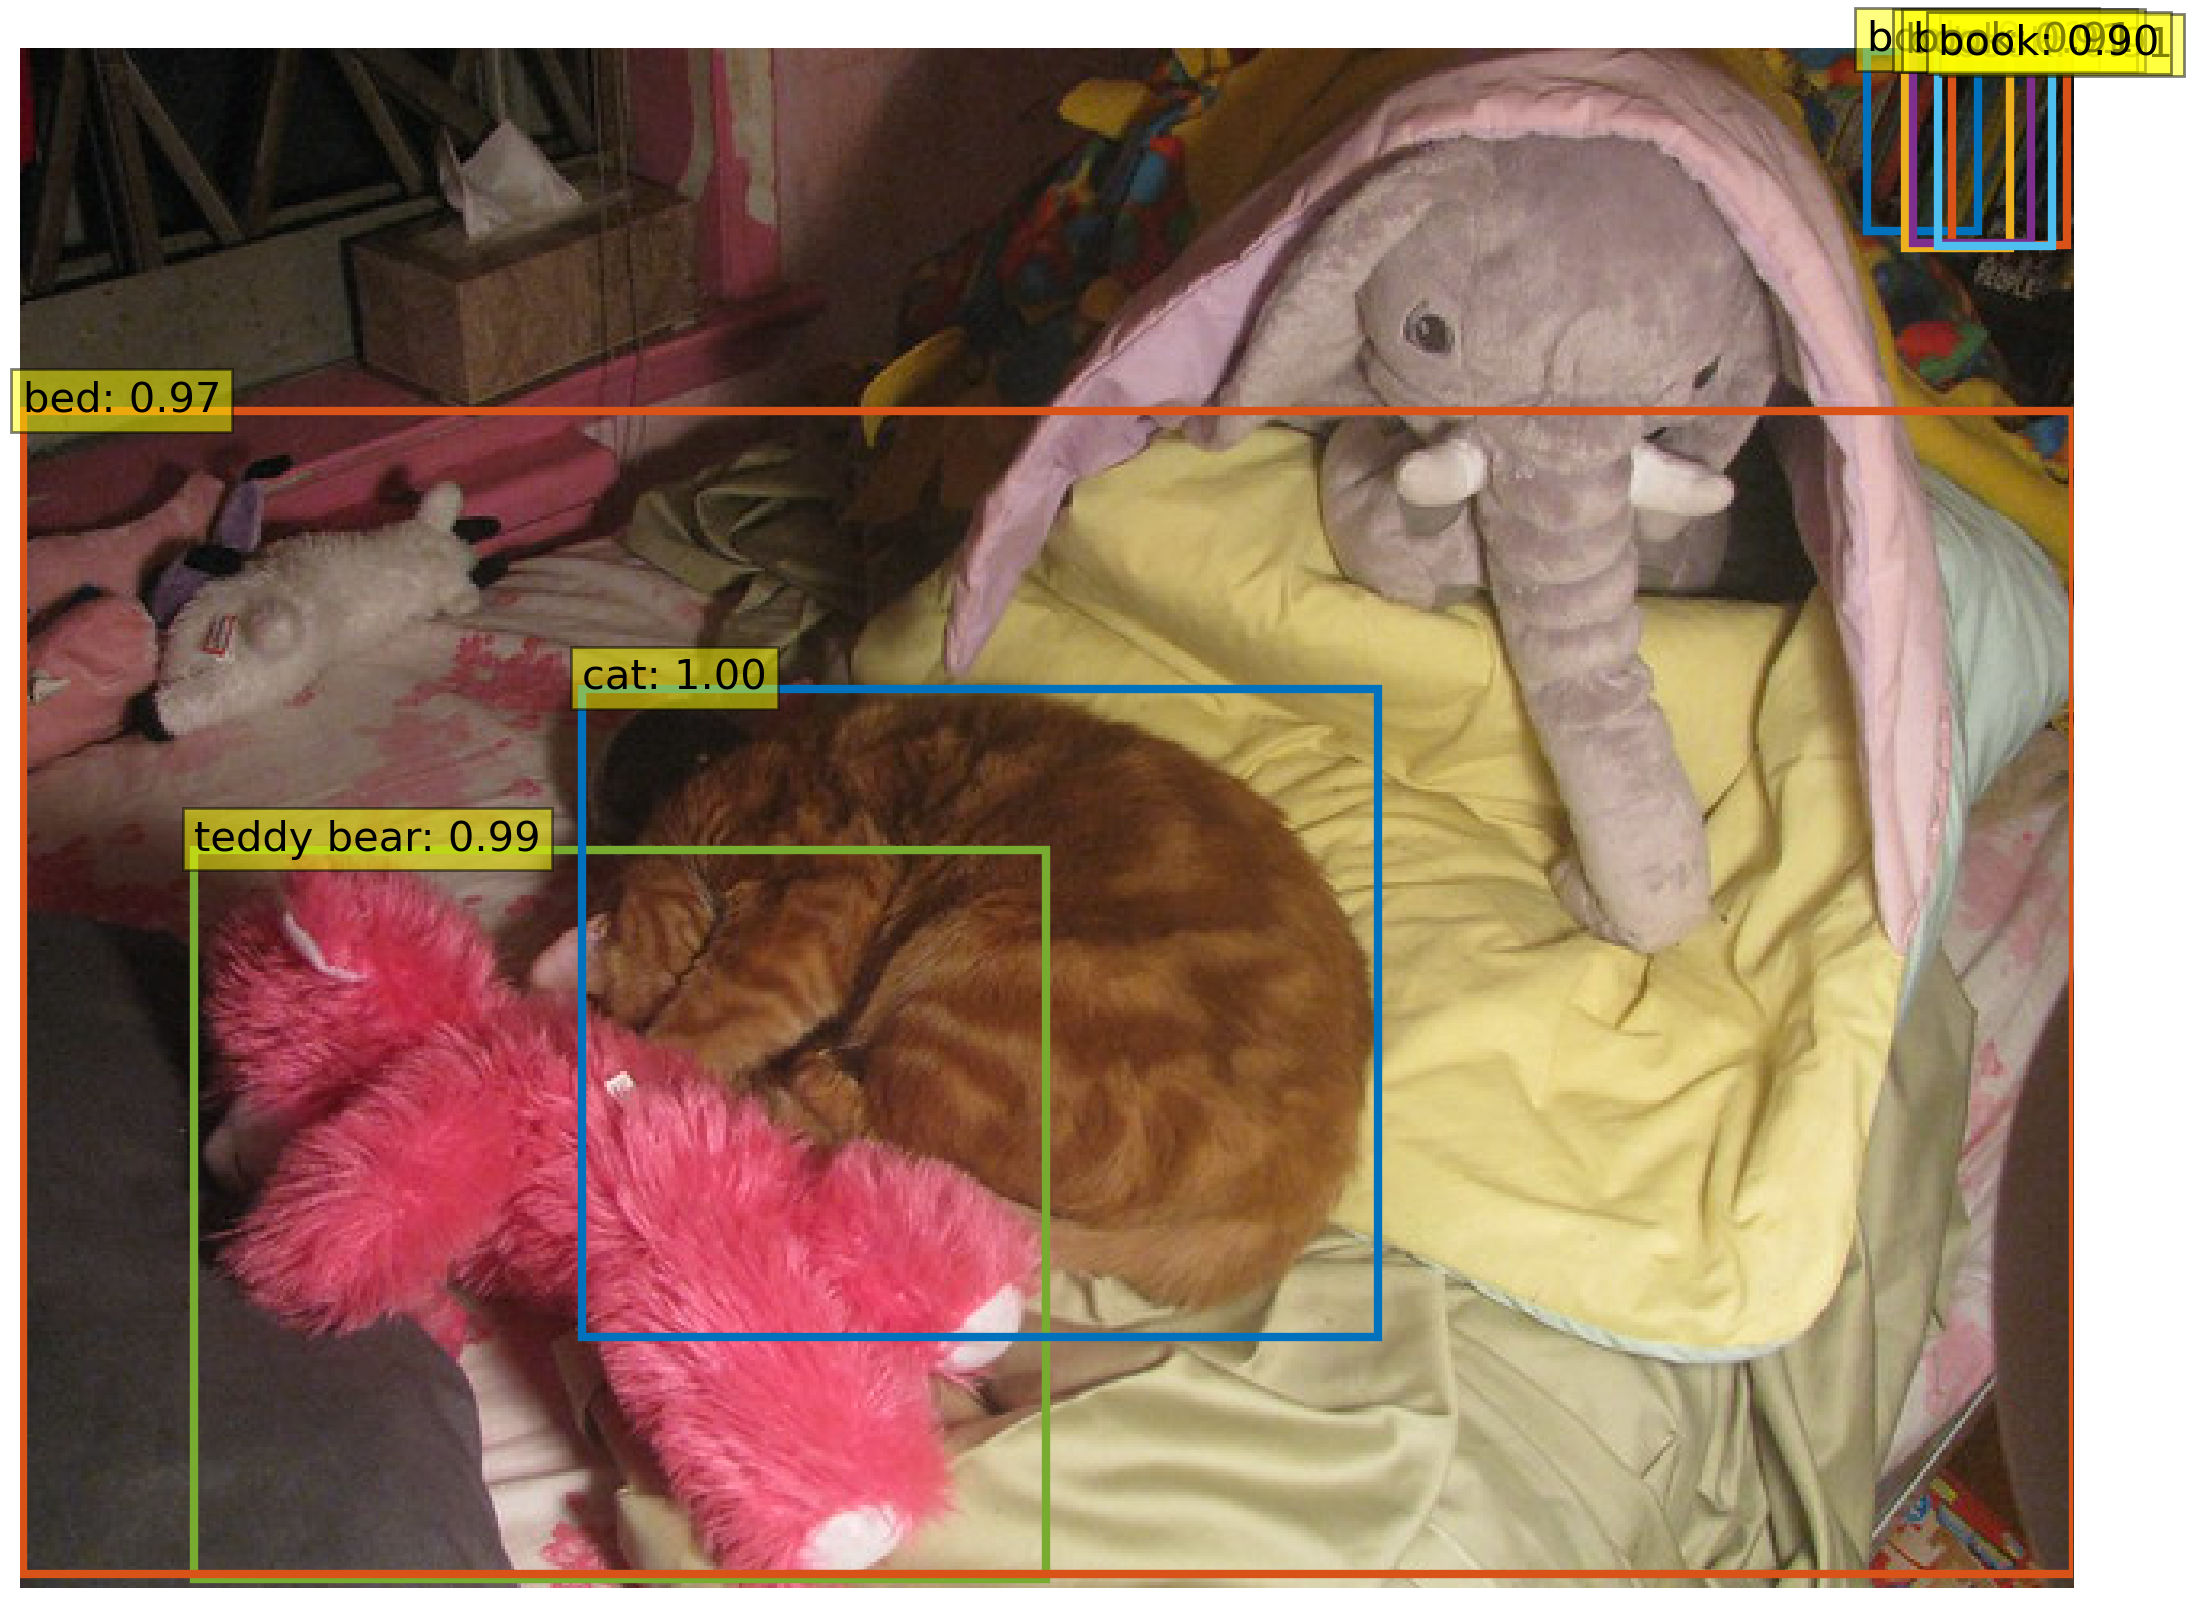

In [43]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# TODO: transform the image using the transform specified above
img = transform(im).unsqueeze(0)

# TODO: propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

# 2. Visualizing Attention Weights

## 2.1. Using the code snippet below as a guide, visualize the encoder and decoder attention weights for each layer of the transformer [25%]

#### Use lists to store the outputs via up-values

```
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[0].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[0].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]
```

#### Propagate through the model

```
outputs = model(img)

for hook in hooks:
    hook.remove()
```

### `Note:` Remember to pop the first element from each list before plotting

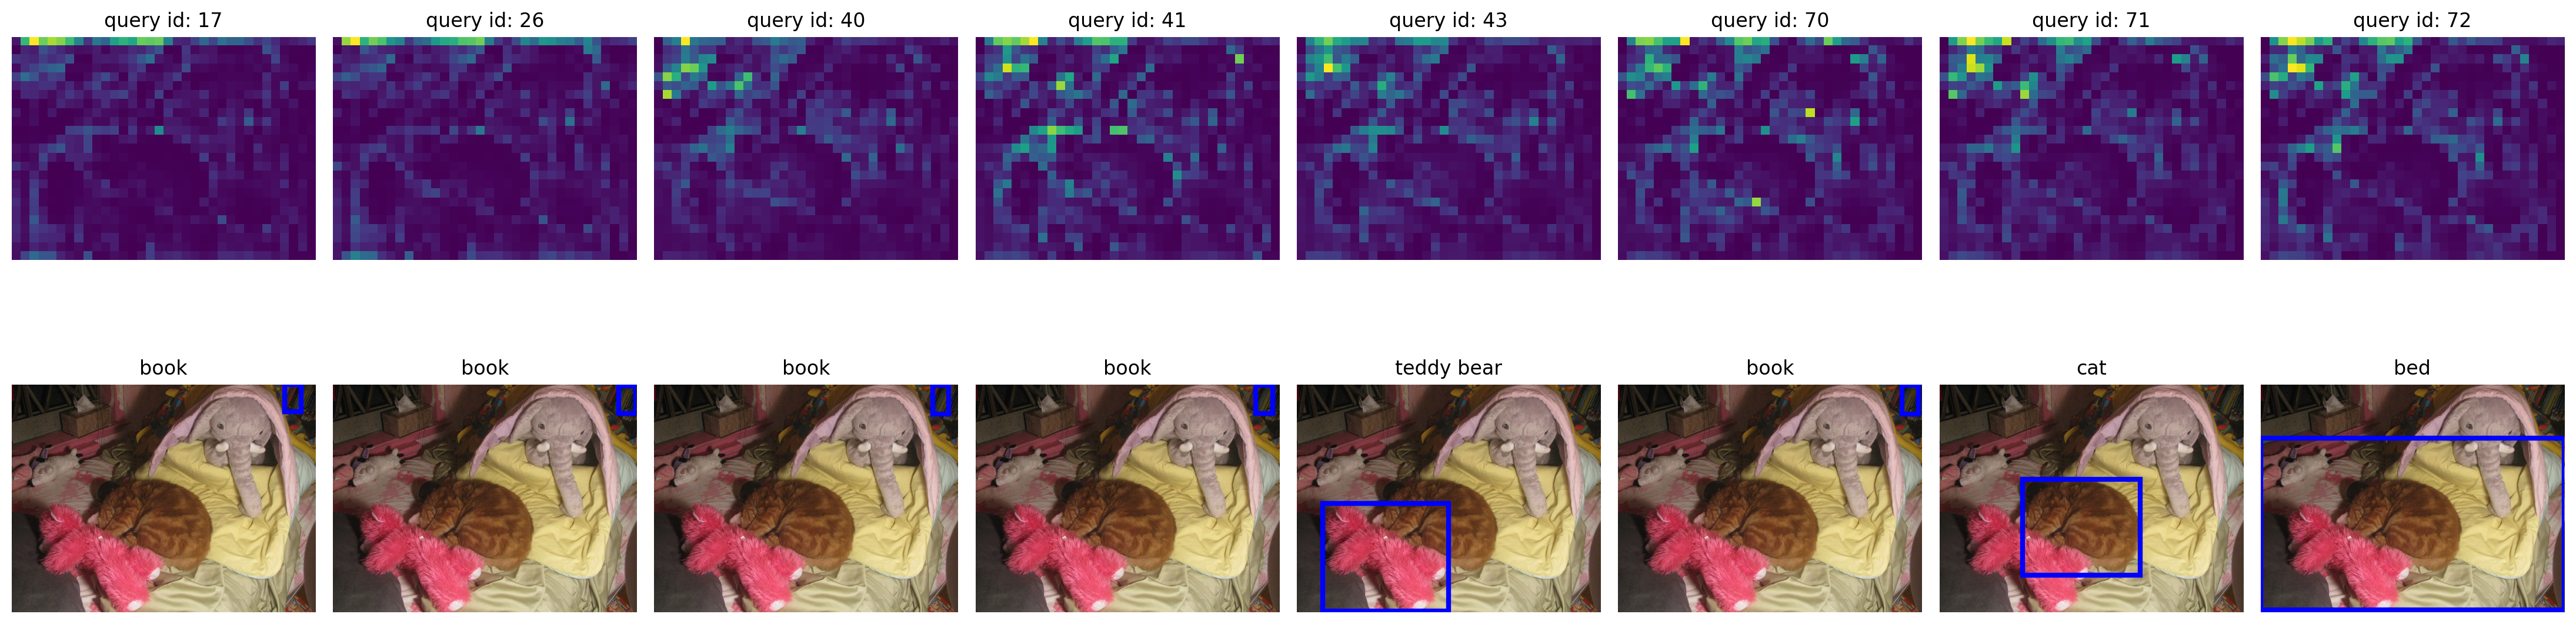

In [44]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

# TODO:
hooks = []

for i in range(0, num_layers):
    hook = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[i].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[i].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        )]
    hooks.append(hook)
    
    
# TODO: propagate through the model
outputs = model(img)

for hookGroup in hooks:
    for hook in hookGroup:
        hook.remove()

# TODO: Pop the elements
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(enc_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

# 2.2. What do you observe? [10%]

Write in your own words

`Answer`
Distinct Attention Areas: Each attention map highlights different areas of the image. This suggests that the model is focusing on different parts of the image when predicting different objects.

Correlation with Object Location: There is a visible correlation between the highlighted areas in the attention maps and the location of the objects in the image. For example, for the query ID associated with the cat, the attention is concentrated around where the cat is located in the image.

Multiple Queries for Same Object: Multiple queries seem to be focusing on the same object, such as the book. This could indicate that the model is using multiple queries to refine its prediction for a single category of objects, which is a common behavior in DETR models.

High Confidence Predictions: The confidence levels for the objects (bed, cat, teddy bear) are very high, indicating that the model is quite certain about its predictions in the bounding boxes.

Attention Outside Bounding Boxes: The attention is not strictly confined to the bounding boxes, especially for larger objects like the bed. This could mean the model is using context from surrounding areas to make its predictions.

Overlapping Bounding Boxes: There's an overlapping of bounding boxes on the teddy bear and the cat, which might indicate either a high correlation between the features of these two objects in the model's perspective or the need for further refinement in the model's discrimination capabilities.

Lastly, before using this image, I was using another image with only one cat as detected object and it did not generate attention map successfully. I have not figured out the reasoning behind yet.

# 3. Using a different backbone

There is another pre-trained DETR model available with a `resnet101` backbone (`detr_resnet101`)

Similar to the `detr_resnet50` backone you used above, visualize bounding boxes and attention maps for each layer of the encoder and decoder using a `resnet101` backbone

### Before downloading resnet101 make sure to clean-up the local_path to not run out of memory

`!rm -r "$local_path""/facebookresearch_detr_main"`

`!rm -r "$local_path""/checkpoints"`

## 3.1 Generating Bounding Boxes [5%]

rm: cannot remove '/home/jovyan/HW4/detr/checkpoints': No such file or directory


Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /home/jovyan/HW4/detr/main.zip
/opt/conda/envs/csciua-0480042-fall/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/jovyan/HW4/detr/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 155MB/s]  
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /home/jovyan/HW4/detr/checkpoints/detr-r101-2c7b67e5.pth
100%|██████████| 232M/232M [00:03<00:00, 67.2MB/s] 


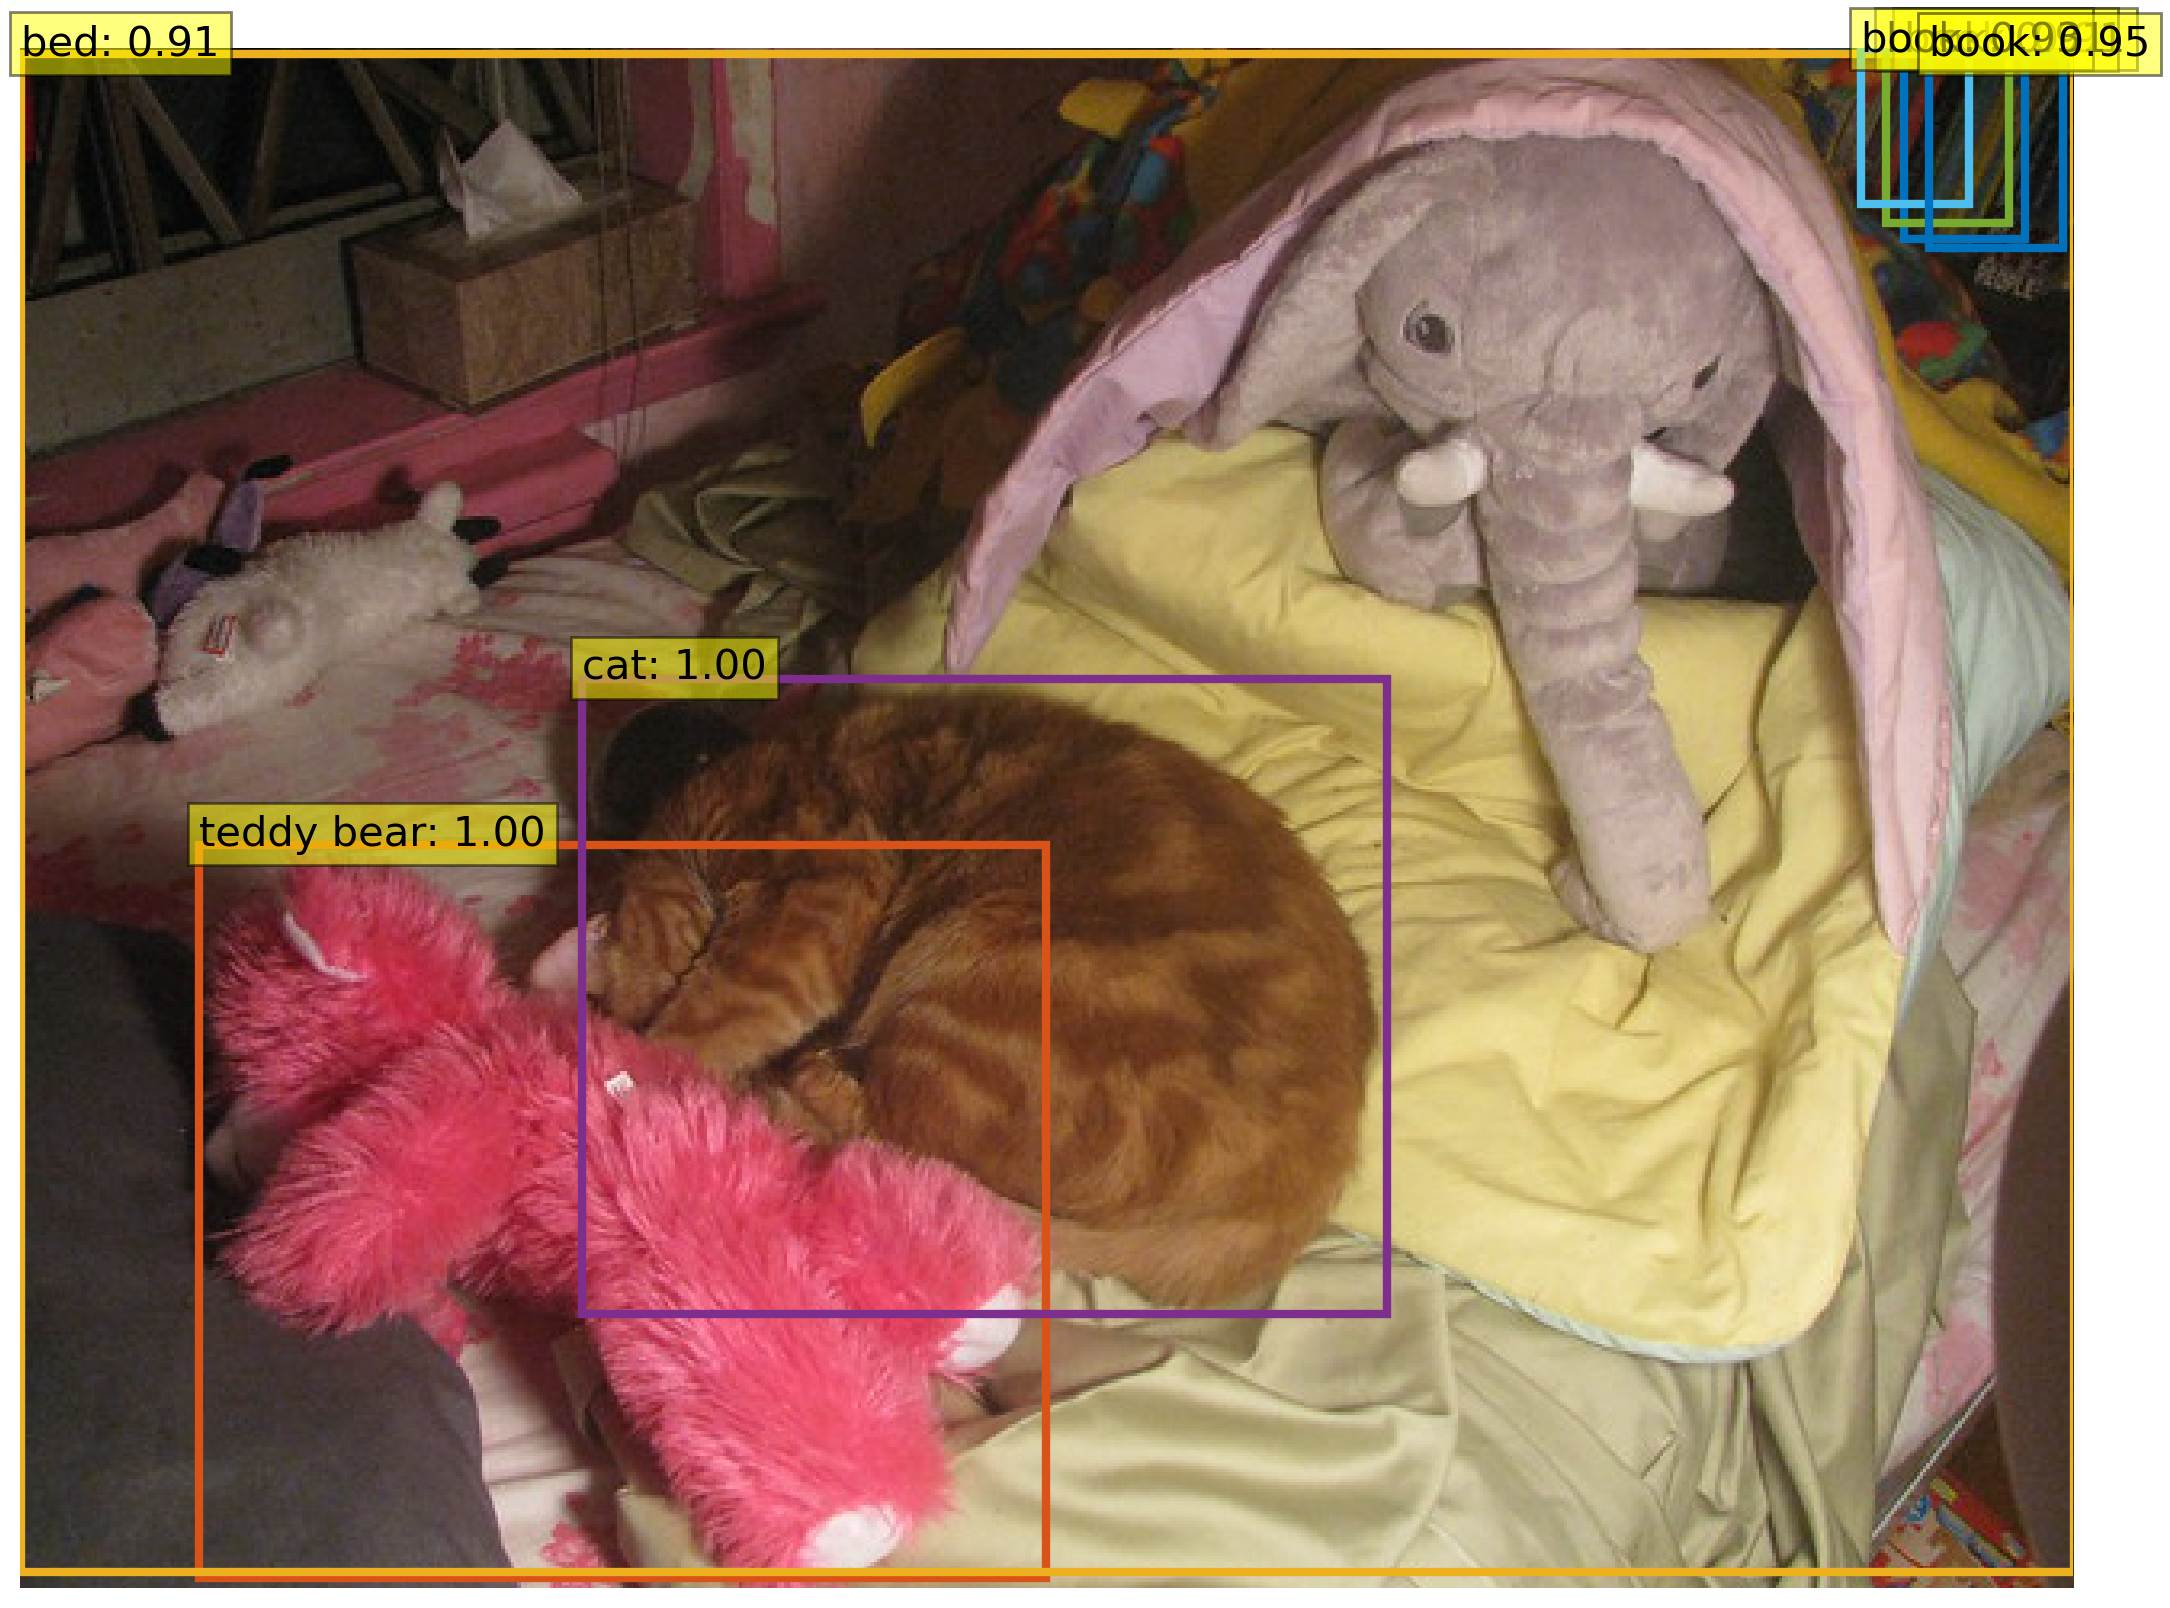

In [46]:
# TODO:
!rm -r "$local_path""/facebookresearch_detr_main"

!rm -r "$local_path""/checkpoints"
torch.hub.set_dir(local_path)
model = torch.hub.load("facebookresearch/detr","detr_resnet101", pretrained=True)
model.eval()

num_layers = 6

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# TODO: transform the image using the transform specified above
img = transform(im).unsqueeze(0)

# TODO: propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

## 3.2 Visualizing Attention Maps [5%]

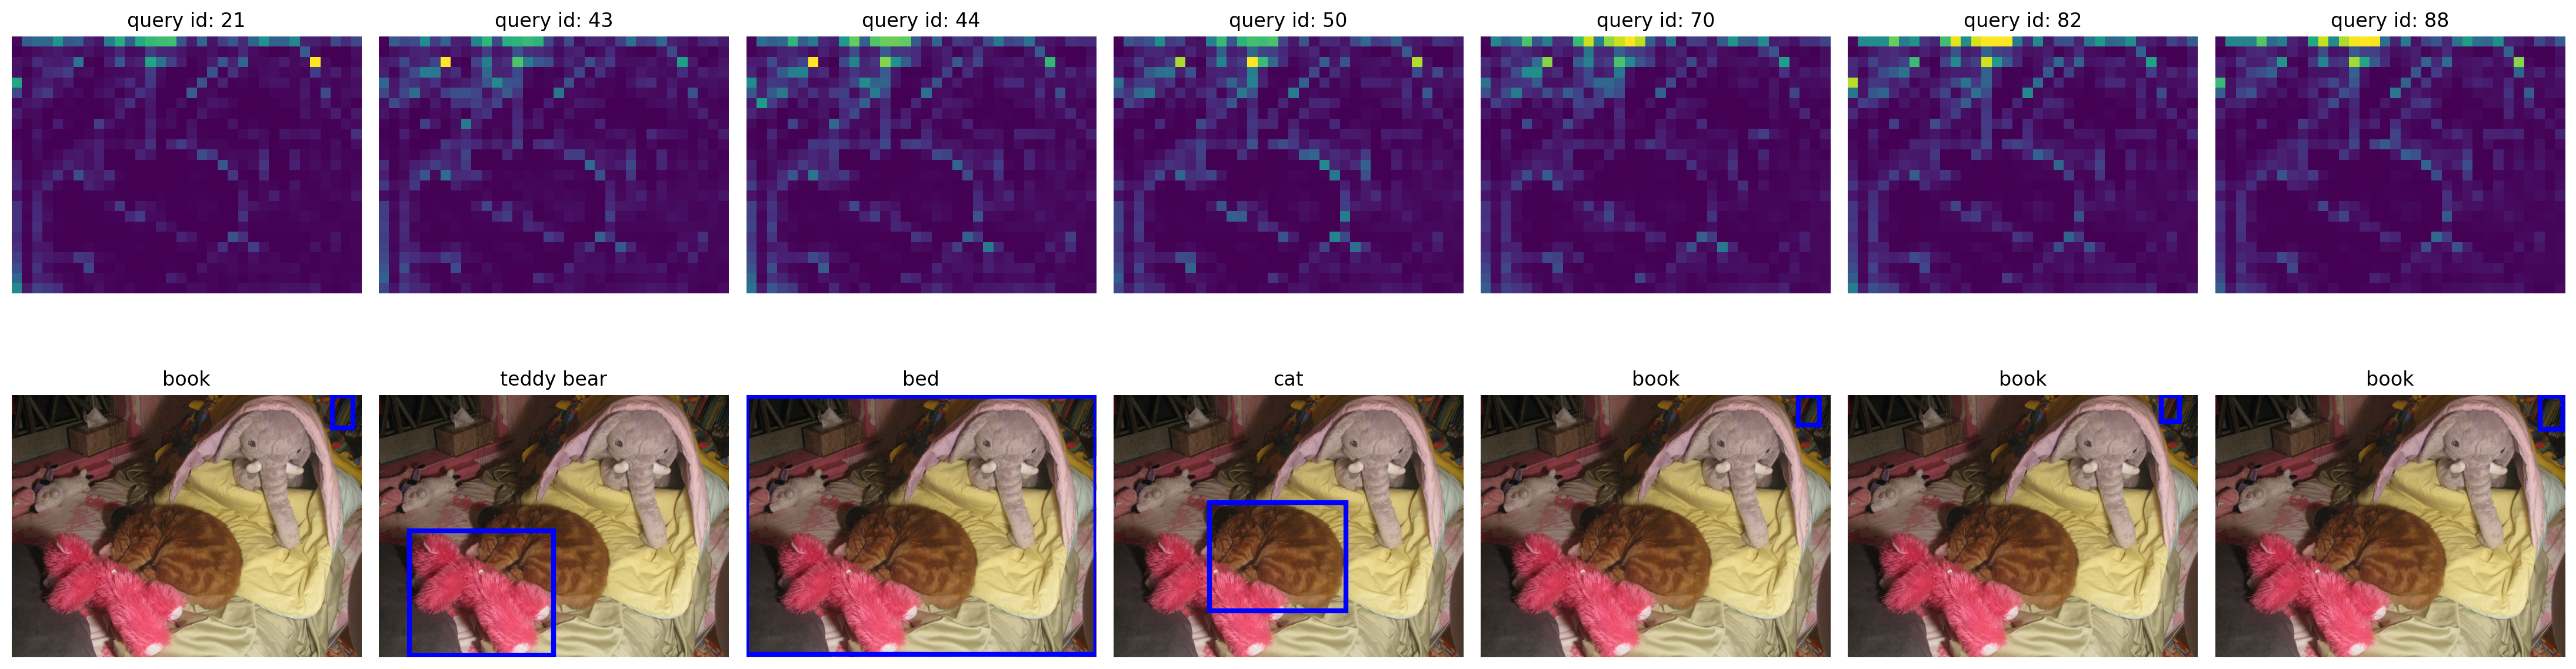

In [47]:
# TODO:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

# TODO:
hooks = []

for i in range(0, num_layers):
    hook = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.encoder.layers[i].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        ),
        model.transformer.decoder.layers[i].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        )]
    hooks.append(hook)
    
    
# TODO: propagate through the model
outputs = model(img)

for hookGroup in hooks:
    for hook in hookGroup:
        hook.remove()

# TODO: Pop the elements
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(enc_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

# 4. What do you observe? How do the visualizations using the 2 different backbones compare? [35%]

Give your insights in a maximum of 100 words

`Answer`
resnet101 is a deeper network with more layers than resnet50, which allows it to potentially capture more complex features. This could result in more detailed attention maps that focus more precisely on the relevant parts of the image. However, I cannot tell the major difference from here. Still, for the attention map generated by resnet101 in this case, there is one book not detected compared to the one generated by resnet50.
The deeper network might lead to higher confidence in predictions. However, boundary boxes generated by resnet101 in this case are minorly lower.
